In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INDF.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,7400.0,7500.0,7375.0,7500.0,5944.014160,9181300
1,2017-12-19,7500.0,7700.0,7475.0,7650.0,6062.894531,15706100
2,2017-12-20,7650.0,7700.0,7425.0,7550.0,5983.640625,14606300
3,2017-12-21,7525.0,7600.0,7475.0,7600.0,6023.267578,10857700
4,2017-12-22,7600.0,7625.0,7575.0,7625.0,6043.080566,4686000


In [3]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [4]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0
...,...,...,...,...,...
1489,2023-12-08,6400.0,6400.0,6425.0,6325.0
1490,2023-12-11,6375.0,6400.0,6400.0,6325.0
1491,2023-12-12,6425.0,6375.0,6425.0,6350.0
1492,2023-12-13,6400.0,6400.0,6425.0,6350.0


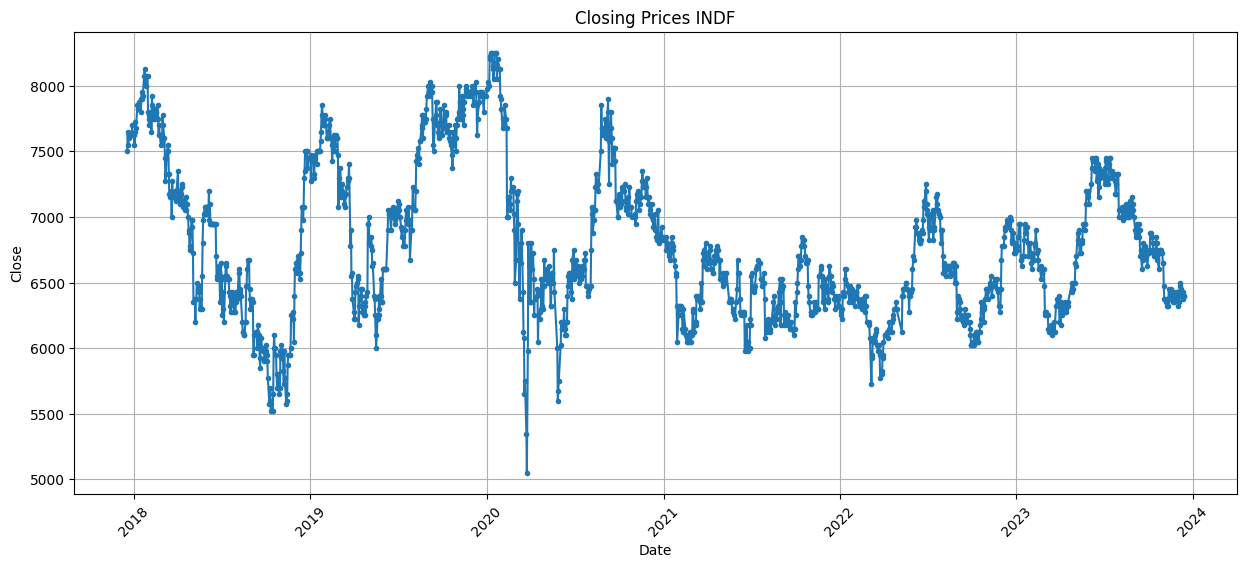

In [5]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

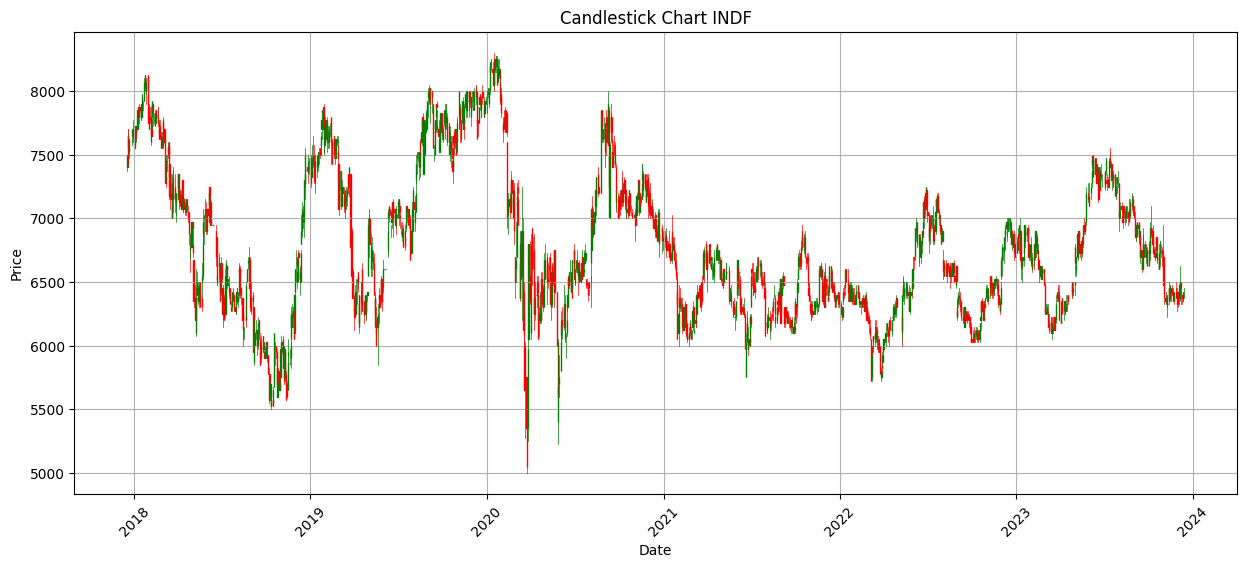

In [6]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart INDF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

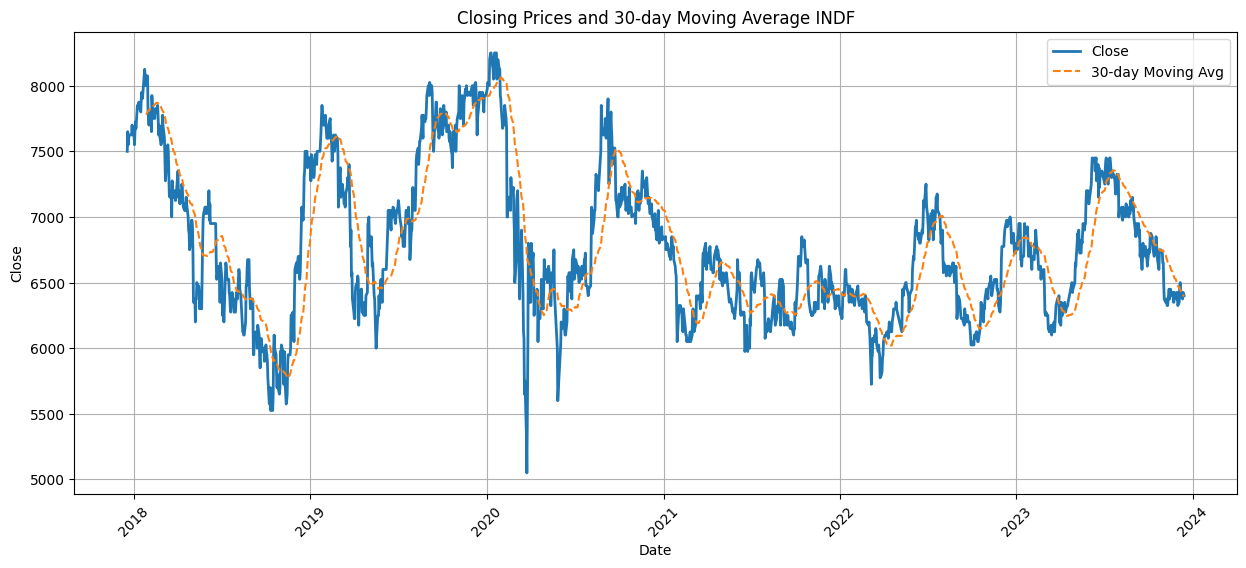

In [7]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0


In [9]:
new_df = specific_df.reset_index()['Close']

In [10]:
new_df

0       7500.0
1       7650.0
2       7550.0
3       7600.0
4       7625.0
         ...  
1489    6400.0
1490    6375.0
1491    6425.0
1492    6400.0
1493    6400.0
Name: Close, Length: 1494, dtype: float64

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

Partisi Data

In [12]:
train_size = int(len(scaled_data)*0.8) #80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1135, 60)
(1135,)


Testing set size:-
(239, 60)
(239,)


(None, None)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
Layer = 3

In [17]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [19]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100

36/36 [==============================] - 33s 262ms/step - loss: 0.1492 - val_loss: 0.0077
Epoch 2/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0888 - val_loss: 0.0166
Epoch 3/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0681 - val_loss: 0.0060
Epoch 4/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0635 - val_loss: 0.0101
Epoch 5/100
36/36 [==============================] - 2s 62ms/step - loss: 0.0506 - val_loss: 0.0115
Epoch 6/100
36/36 [==============================] - 2s 65ms/step - loss: 0.0513 - val_loss: 0.0118
Epoch 7/100
36/36 [==============================] - 2s 63ms/step - loss: 0.0437 - val_loss: 0.0070
Epoch 8/100
36/36 [==============================] - 2s 67ms/step - loss: 0.0396 - val_loss: 0.0062
Epoch 9/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0380 - val_loss: 0.0071
Epoch 10/100
36/36 [==============================] - 3s 76ms/step - loss: 0.0360 - val_loss: 0.0

In [21]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 22ms/step


In [22]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [23]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.06950099048047256
0.0432948963127126


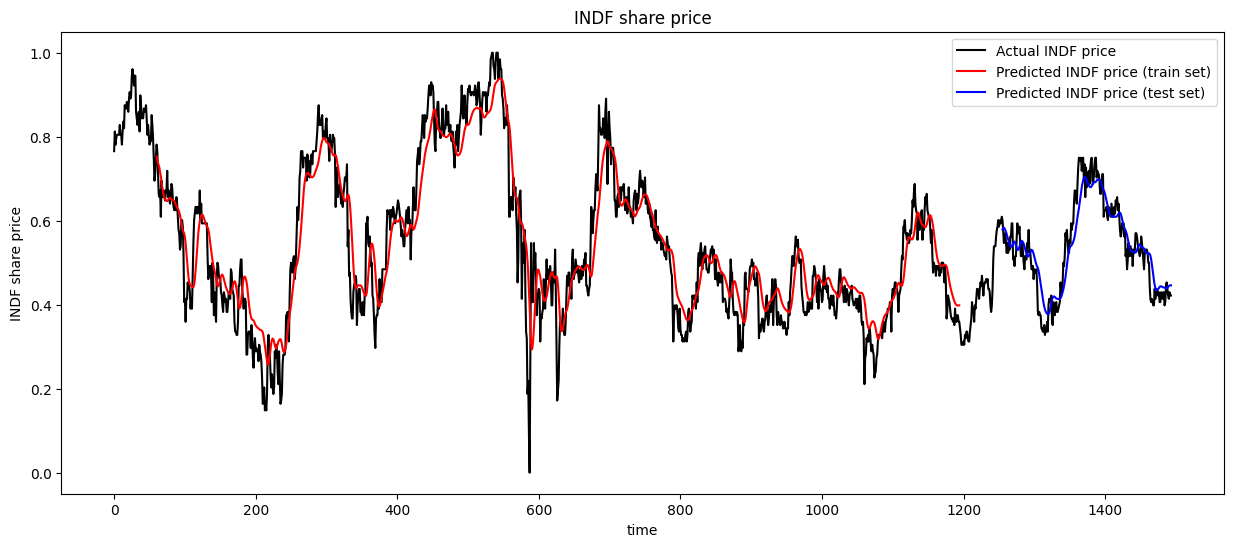

In [24]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [25]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 373ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6477.50244140625
Day 2: Predicted Price = 6478.306640625
Day 3: Predicted Price = 6481.4638671875
Day 4: Predicted Price = 6486.88720703125
Day 5: Predicted Price = 6493.97265625
Day 6: Predicted Price = 6502.01708984375
Day 7: Predicted Price = 6510.4306640625
Day 8: Predicted Price = 6518.80029296875
Day 9: Predicted Price = 6526.8837890625
Day 10: Predicted Price = 6534.564453125
Day 11: Predicted Price = 6541.8154296875
Day 12: Predicted Price = 6548.65185546875
Day 13: Predicted Price = 6555.11328125
Day 14: Predicted Price = 6561.24267578125
Day 15: Predicted Price = 6567.07763671875
Day 16: Predicted Price = 6572.65087890625
Day 17: Predicted Price = 6577.9892578125
Day 18: Predicted Price = 6583.10986328125
Day 19: Predicted Price = 6588.03173828125
Day 20: Predicted Price = 6592.76513671875
Day 21: Predicted Price = 6597.31982421875
Day 22: Predicted Price = 6601.706

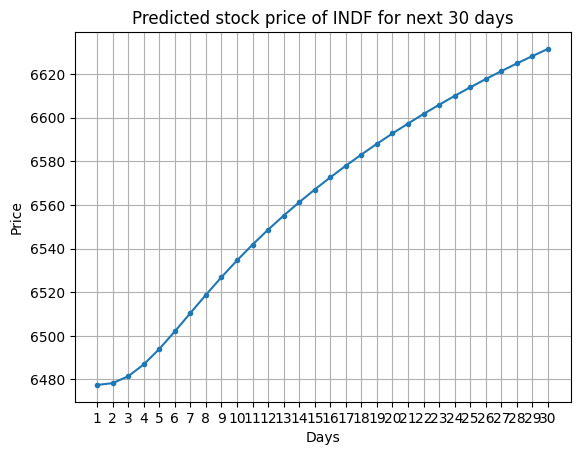

In [26]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [27]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 24ms/step - loss: 0.0019
Validation Loss: 0.0018744480330497026
Validation MSE Loss: 0.0018744480330497026


In [28]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.06950099048047256
Testing RMSE: 0.0432948963127126


Layer = 4

In [29]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50)               

In [31]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 43s 325ms/step - loss: 0.1534 - val_loss: 0.0176
Epoch 2/100
36/36 [==============================] - 4s 100ms/step - loss: 0.0821 - val_loss: 0.0278
Epoch 3/100
36/36 [==============================] - 4s 99ms/step - loss: 0.0823 - val_loss: 0.0208
Epoch 4/100
36/36 [==============================] - 4s 98ms/step - loss: 0.0701 - val_loss: 0.0143
Epoch 5/100
36/36 [==============================] - 4s 98ms/step - loss: 0.0565 - val_loss: 0.0264
Epoch 6/100
36/36 [==============================] - 4s 103ms/step - loss: 0.0538 - val_loss: 0.0118
Epoch 7/100
36/36 [==============================] - 4s 103ms/step - loss: 0.0500 - val_loss: 0.0079
Epoch 8/100
36/36 [==============================] - 4s 99ms/step - loss: 0.0481 - val_loss: 0.0179
Epoch 9/100
36/36 [==============================] - 3s 92ms/step - loss: 0.0405 - val_loss: 0.0093
Epoch 10/100
36/36 [==============================] - 3s 94ms/step - loss: 0.0428 - val_loss: 0

In [33]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 22ms/step


In [34]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [35]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))


0.07855308496974721
0.054759944989235886


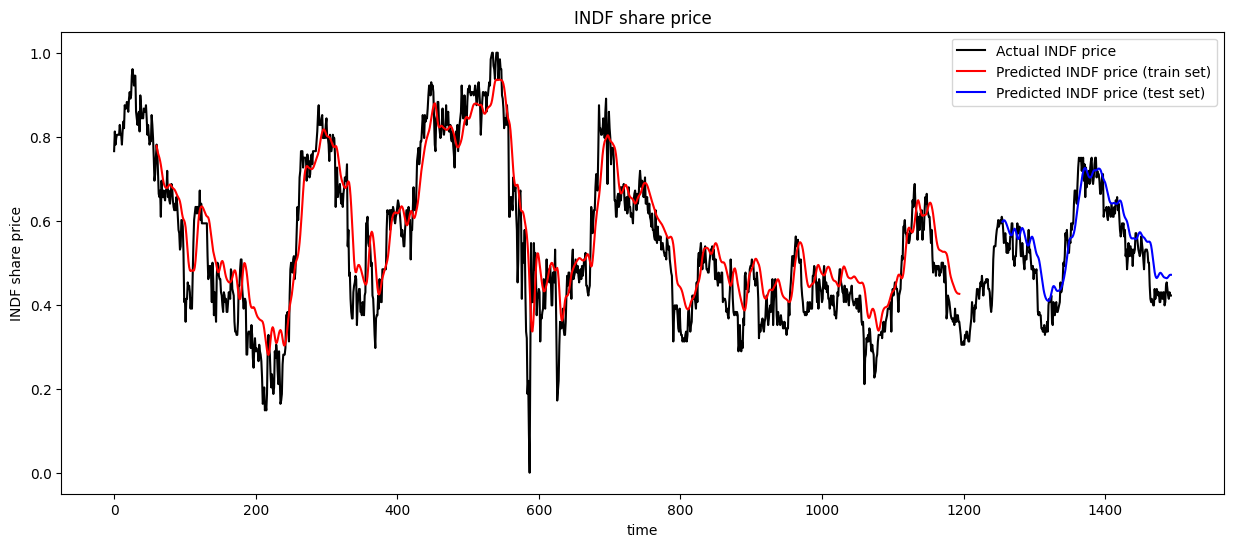

In [36]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [37]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 62ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6557.962890625
Day 2: Predicted Price = 6558.46240234375
Day 3: Predicted Price = 6563.34619140625
Day 4: Predicted Price = 6574.0341796875
Day 5: Predicted Price = 6589.84619140625
Day 6: Predicted Price = 6608.9072265625
Day 7: Predicted Price = 6629.125
Day 8: Predicted Price = 6648.85791015625
Day 9: Predicted Price = 6667.1689453125
Day 10: Predicted Price = 6683.78515625
Day 11: Predicted Price = 6698.873046875
Day 12: Predicted Price = 6712.8037109375
Day 13: Predicted Price = 6725.970703125
Day 14: Predicted Price = 6738.68017578125
Day 15: Predicted Price = 6751.1201171875
Day 16: Predicted Price = 6763.37451171875
Day 17: Predicted Price = 6775.4560546875
Day 18: Predicted Price = 6787.3505859375
Day 19: Predicted Price = 6799.0302734375
Day 20: Predicted Price = 6810.47802734375
Day 21: Predicted Price = 6821.69189453125
Day 22: Predicted Price = 6832.67431640625
Da

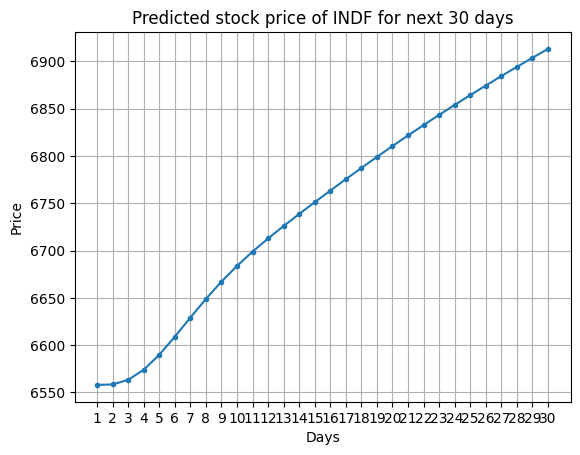

In [38]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [39]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 28ms/step - loss: 0.0030
Validation Loss: 0.0029986517038196325
Validation MSE Loss: 0.0029986517038196325


In [40]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.07855308496974721
Testing RMSE: 0.054759944989235886


Layer = 5

In [41]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)           

In [43]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [44]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 21s 190ms/step - loss: 0.1585 - val_loss: 0.0258
Epoch 2/100
36/36 [==============================] - 4s 102ms/step - loss: 0.0815 - val_loss: 0.0171
Epoch 3/100
36/36 [==============================] - 4s 103ms/step - loss: 0.0688 - val_loss: 0.0236
Epoch 4/100
36/36 [==============================] - 4s 104ms/step - loss: 0.0634 - val_loss: 0.0145
Epoch 5/100
36/36 [==============================] - 4s 101ms/step - loss: 0.0575 - val_loss: 0.0212
Epoch 6/100
36/36 [==============================] - 4s 104ms/step - loss: 0.0571 - val_loss: 0.0138
Epoch 7/100
36/36 [==============================] - 4s 104ms/step - loss: 0.0497 - val_loss: 0.0146
Epoch 8/100
36/36 [==============================] - 231s 7s/step - loss: 0.0431 - val_loss: 0.0114
Epoch 9/100
36/36 [==============================] - 5s 138ms/step - loss: 0.0416 - val_loss: 0.0085
Epoch 10/100
36/36 [==============================] - 4s 124ms/step - loss: 0.0412 - val_lo

In [45]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 22ms/step


In [46]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [47]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))


0.09276956684257823
0.05917528432784826


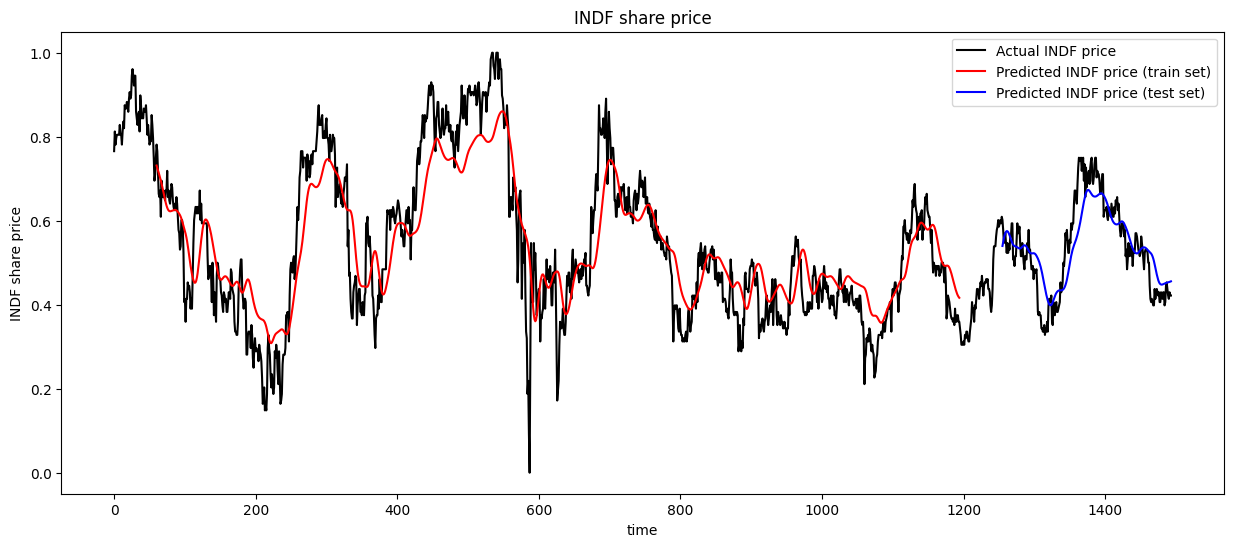

In [48]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [49]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 27ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6508.15576171875
Day 2: Predicted Price = 6510.24072265625
Day 3: Predicted Price = 6512.47705078125
Day 4: Predicted Price = 6515.185546875
Day 5: Predicted Price = 6518.6630859375
Day 6: Predicted Price = 6523.0927734375
Day 7: Predicted Price = 6528.51025390625
Day 8: Predicted Price = 6534.81591796875
Day 9: Predicted Price = 6541.80615234375
Day 10: Predicted Price = 6549.22705078125
Day 11: Predicted Price = 6556.8173828125
Day 12: Predicted Price = 6564.3447265625
Day 13: Predicted Price = 6571.62841796875
Day 14: Predicted Price = 6578.55078125
Day 15: Predicted Price = 6585.048828125
Day 16: Predicted Price = 6591.1103515625
Day 17: Predicted Price = 6596.7587890625
Day 18: Predicted Price = 6602.03857421875
Day 19: Predicted Price = 6607.0009765625
Day 20: Predicted Price = 6611.69873046875
Day 21: Predicted Price = 6616.17724609375
Day 22: Predicted Price = 6620.472

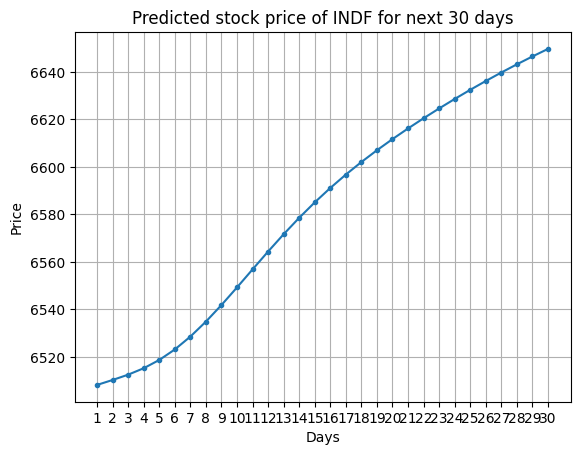

In [50]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [51]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 18ms/step - loss: 0.0035
Validation Loss: 0.003501714440062642
Validation MSE Loss: 0.003501714440062642


In [52]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.09276956684257823
Testing RMSE: 0.05917528432784826


Layer = 6

In [53]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 60, 50)           

In [55]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [56]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 14s 173ms/step - loss: 0.1550 - val_loss: 0.0272
Epoch 2/100
36/36 [==============================] - 4s 120ms/step - loss: 0.0919 - val_loss: 0.0267
Epoch 3/100
36/36 [==============================] - 4s 112ms/step - loss: 0.0819 - val_loss: 0.0460
Epoch 4/100
36/36 [==============================] - 4s 109ms/step - loss: 0.0680 - val_loss: 0.0147
Epoch 5/100
36/36 [==============================] - 3s 92ms/step - loss: 0.0598 - val_loss: 0.0188
Epoch 6/100
36/36 [==============================] - 3s 87ms/step - loss: 0.0600 - val_loss: 0.0088
Epoch 7/100
36/36 [==============================] - 3s 97ms/step - loss: 0.0536 - val_loss: 0.0126
Epoch 8/100
36/36 [==============================] - 3s 97ms/step - loss: 0.0485 - val_loss: 0.0139
Epoch 9/100
36/36 [==============================] - 3s 98ms/step - loss: 0.0507 - val_loss: 0.0124
Epoch 10/100
36/36 [==============================] - 4s 100ms/step - loss: 0.0453 - val_loss: 

In [57]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 35ms/step


In [58]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [59]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))


0.08445300145812487
0.054000855203923885


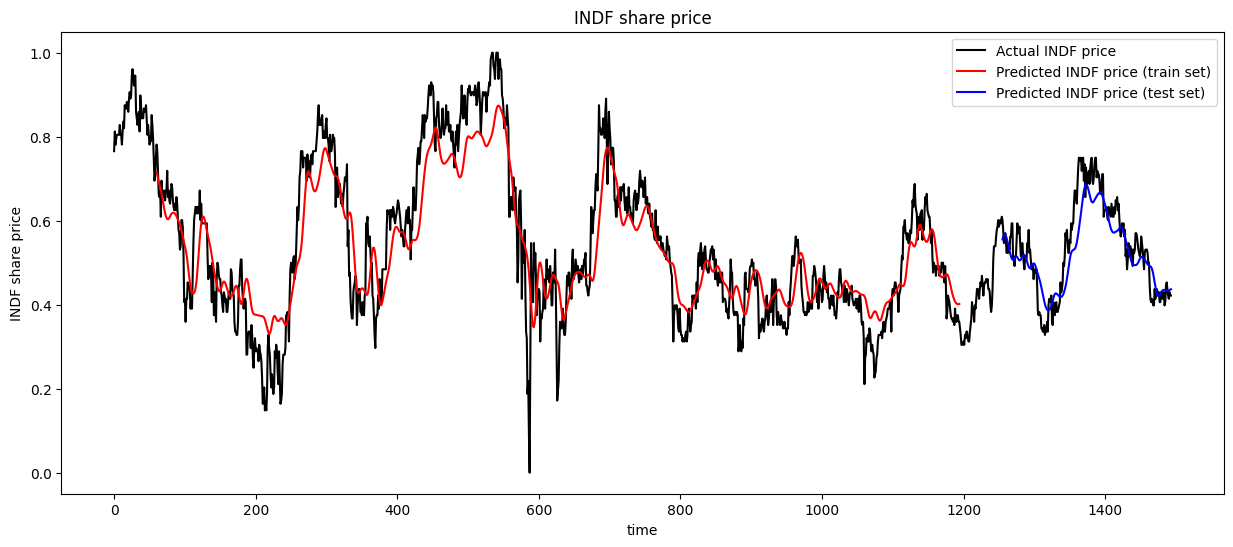

In [60]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [61]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 26ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6448.13671875
Day 2: Predicted Price = 6450.95751953125
Day 3: Predicted Price = 6452.88916015625
Day 4: Predicted Price = 6454.240234375
Day 5: Predicted Price = 6455.443359375
Day 6: Predicted Price = 6456.8681640625
Day 7: Predicted Price = 6458.708984375
Day 8: Predicted Price = 6460.9853515625
Day 9: Predicted Price = 6463.57177734375
Day 10: Predicted Price = 6466.28125
Day 11: Predicted Price = 6468.91943359375
Day 12: Predicted Price = 6471.337890625
Day 13: Predicted Price = 6473.45263671875
Day 14: Predicted Price = 6475.24267578125
Day 15: Predicted Price = 6476.73046875
Day 16: Predicted Price = 6477.9677734375
Day 17: Predicted Price = 6479.013671875
Day 18: Predicted Price = 6479.91943359375
Day 19: Predicted Price = 6480.72412109375
Day 20: Predicted Price = 6481.45068359375
Day 21: Predicted Price = 6482.1103515625
Day 22: Predicted Price = 6482.70556640625
Day

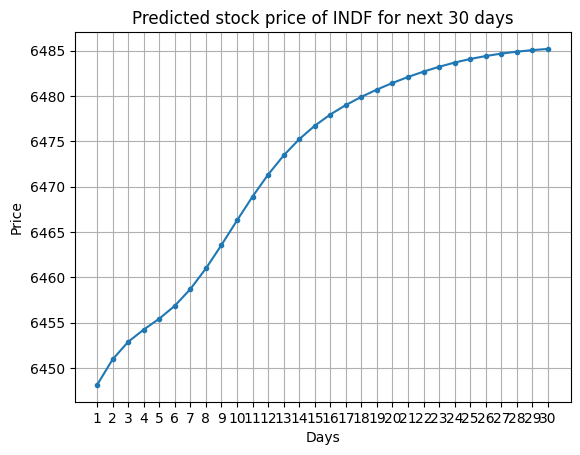

In [62]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [63]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 30ms/step - loss: 0.0029
Validation Loss: 0.002916092751547694
Validation MSE Loss: 0.002916092751547694


In [64]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.08445300145812487
Testing RMSE: 0.054000855203923885


: 